## Creating a dataframe

This file takes a directory and processes the files in the given format, creating a <span style="color: green"> pickle </span> file.

---


#### <span style="color: red">Question</span>

I can see coordinates for fibrosis countour inside the .txt files:

 - What is the correct way to read and use said data?
 - Should I use them as segmentation, or should I develop/use transfer learning for a segmentation algorithm?
 - In cases with no fibrosis, how would i perform segmentation? Simply the relevant lung parts?

#### <span style="color: green">Answer</span>

For now, not relevant. Lung masks are not needed right now, at least for simple binary classification, I can juist give numpy arrays of the entire DICOM file.


---

Imports

In [38]:
import os
import re
import pickle
import random
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Export dataframe as .csv if only ID -> Label, .pkl otherwise

In [6]:
# Setting variables 

#root_dir = 'X:\\RafaelAndre\\MedGIFT\\ILD_DB_txtROIs'

root_dir = 'D:\\Rafa\\A1Uni\\2semestre\\Estágio\\data\\ILD_DB_txtROIs'

#root_dir = 'C:\\Users\\hasht\\Desktop\\Cloned Repositories\\fibrosis_dataset\\ILD_DB_txtROIs'

## Code Planification and Intuition


### Identify folders with nested folders

This will help with os.walk issues down the line, due to potential exceptional folder name/number cases.

 - Enter folder
    - If has subfolders, add to list
    - Then, for each subfolder, apply function below

### Main function

This aims to obtain each file's id, as well as its respective DICOM data (transformed into tangible lossless data structures) and fibrosis classification in such a way that they can only be correctly assigned.

 - Get number of slices, num_slices = number of files in folder - 1
 - Get all file names except txt, and for each do name = str(parent_folder) + str(file_name) and put them in a list, where they are all in ascending order according to the number represented by the last 4 digits of each file name
 - For each file in that list, transform DICOM images into lossless np.array or matrix, place into data_dict, like {file_name: lossless_data_structure}
 - Enter all pairs into classification_dict, like {file_name:0}
 - Find .txt file
    - read line by line:

**The loop structure below makes it easy to identify id's in the dataframe, as they are named "folder_number + slice_id", and in a later implementation will contain every respective slice data.**

While reading line by line:
 - find first occurrence of "fibrosis"
   
   - After finding fibrosis, start new loop until new "label" is found, and is not "label: fibrosis". For every "slice_number: num" found, get slice_file_name = file_names[num-1] (as the slices start at 1) (id: 1) to dictionary.

   - If a new "label" is found and is not "label: fibrosis", then each slice_num under it does not count as it is not fibrosis. 
   
   - Until the .txt file is not completely read, we keep searching for the "fibrosis" keyword, and repeating the loop above.

### Dataframe creation and export

After each folder iteration, the dictionary keeps being updated, and when all folders are finally analyzed, I should have a dataset with slice id's and their respective fibrosis classification.

This means that I can use the {key,value} pairs inside the dictionary as data for the pandas library to build a tangible dataframe.

The column names will be `SliceID`, `SliceData` and `Class`, where classification as 1 means that fibrosis is present, and 0 otherwise.

**`Important:`** This type of data should not be stored in a .csv file, as the numpy arrays will be converted to strings, making it necessary to re-map them into arrays every time that file needs to be read. Pickle files are recommended. Creating, saving and reading `.pkl` files is demonstrated below.

In [7]:
# Obtains folders with subfolders
def get_nested(base_path):
    has_sub = []
    for root, dirs, files in os.walk(base_path):
        if dirs: has_sub.append(root)
    return has_sub

In [8]:
# Expected number of lines for the dataframe
def count_dcm_files(directory):
    count = 0
    for root, _, files in os.walk(directory):  
        count += sum(1 for file in files if file.lower().endswith(".dcm"))
    print(f"Number of .dcm files | Expected lines in dataframe: {count}")

count_dcm_files(root_dir)

Number of .dcm files | Expected lines in dataframe: 3075


In [9]:
# ID creation
def addNumeric(root, subfolder):
    try: 
        match = re.search(r'(\d+)$', root)  # Extracts the last full number
    
        if match:
            # in order to easily identify nested cases, I use the "__" flag in between subfolder - nested - dicom
            return f"{match.group(1)}__{subfolder}"  
    except Exception as e: print(f"ERROR ON FOLDER {subfolder}: {e}")

In [10]:
# Obtains DICOM as np.array for a specified folder
def get_dicom_lossless(folder_path):

    # Get file names in ascending order
    file_names = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.dcm')],
        key=lambda x: int(x[-8:-4])  # Last 4 digits of filename for sorting
    )
    
    # Create relevant dictionaries
    num_slices = len(file_names)
    data_dict = {}
    classification_dict = {}
    
    # Read DICOM files and store as numpy arrays
    for file_name in file_names:
        dicom_path = os.path.join(folder_path, file_name)
        dicom_data = pydicom.dcmread(dicom_path)
        np_array = dicom_data.pixel_array.astype(np.float32)  

        # Creates {key,value} as {file_name, 0}
        data_dict[file_name] = np_array 
        classification_dict[file_name] = 0  
    
    # Pull txt file
    txt_file = next((f for f in os.listdir(folder_path) if f.endswith('.txt')), None)
    
    # If a txt file is found, start reading line by line
    if txt_file:
        txt_path = os.path.join(folder_path, txt_file)
        with open(txt_path, 'r') as file:
            lines = file.readlines()
            fibrosis_found = False
            
            for line in lines:
                line = line.strip().lower()
                
                # Finds fibrosis, enables flag
                if "fibrosis" in line:
                    fibrosis_found = True  
                    continue
                
                if fibrosis_found:

                    # Flag reset condition
                    if "label" in line and "fibrosis" not in line:
                        fibrosis_found = False  

                    # Otherwise, for each slice_number, update {key,value}
                    elif "slice_number:" in line:

                        # Pull slice number, use as index
                        slice_num = int(line.split(':')[-1].strip())
                        if 1 <= slice_num <= num_slices:
                            classification_dict[file_names[slice_num - 1]] = 1 
    
    return data_dict, classification_dict

In [11]:
def create_dataframe(base_path):
    full_dict = {}
    subfolder_check = []
    
    # Iterate through each folder
    for root, dirs, _ in os.walk(base_path):
        for subfolder in dirs:
            folder_path = os.path.join(root, subfolder)

            if subfolder not in subfolder_check:
                if str(subfolder).isnumeric() and int(subfolder) >= 200: subfolder_check.append("HRCT_Pilot" + "__" + subfolder)
                elif str(subfolder[0]).isnumeric(): subfolder_check.append(subfolder)
                else: subfolder_check.append(addNumeric(root, subfolder))
            
            if os.path.isdir(folder_path):

                try:
                    info_dict, class_dict = get_dicom_lossless(folder_path)
                    
                    for file_name, slice_data in info_dict.items():
                        if subfolder ==  None: print(file_name)
                        if str(subfolder).isnumeric() and int(subfolder) >= 200: 
                            subfolder = ("HRCT_Pilot" + "__" + subfolder)
                        #elif str(subfolder).isnumeric() and int(subfolder) < 200: subfolder = subfolder
                        elif str(subfolder[0]).isalpha() and "HRCT_Pilot" not in subfolder: subfolder = addNumeric(root, subfolder)
                        full_dict[subfolder + '__' + file_name[:-4]] = (slice_data, class_dict[file_name])
                except Exception as e:
                    print(f"Error processing folder {folder_path}: {e}")
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame([(k, v[0], v[1]) for k, v in full_dict.items()], columns=["SliceID", "SliceData", "Class"])
    
    print(subfolder_check)
    return df

## Running dataframe creation

In [12]:
req = input("Do you wish to run entire code (y) or read the pickle file (n)?")

if req == "y": df_fibrosis = create_dataframe(root_dir)
else: df_fibrosis = pd.read_pickle(r'C:\\Users\\hasht\Desktop\\fibrosis_data.pkl')

['101', '105', '107', '108', '109', '112', '116', '118', '119', '12', '120', '121', '122', '123', '124', '126', '127', '128', '129', '130', '131', '132', '134', '135', '136', '137', '138', '140', '142', '143', '144', '147', '149', '150', '152', '153', '154', '155', '157', '158', '159', '160', '162', '163', '164', '165', '166', '167', '168', '169', '17', '171', '172', '173', '174', '175', '177', '179', '180', '181', '182', '183', '184', '185', '19', '21', '23', '3', '34', '35', '36', '37', '38', '39', '41', '45', '46', '47', '48', '51', '53', '56', '57', '62', '65', '66', '7', '70', '74', '76', '77', '78', '8', '80', '81', '82', '83', '84', '89', '90', '92', '94', None, '142__CT-INSPIRIUM-2950', '142__CT-INSPIRIUM-2951', '154__CT-INSPIRIUM-6409', '154__CT-INSPIRIUM-6410', '184__CT-INSPIRIUM-5841', '184__CT-INSPIRIUM-5842', '53__CT-INSPIRIUM-1841', '53__CT-INSPIRIUM-7605', '57__CT--0002', '57__CT-INSPIRIUM-3550', '57__CT-series-5652', '8__CT-INSPIRIUM-8871', '8__CT-INSPIRIUM-8873', 'HRCT

In [40]:
# Save DataFrame as a pickle file

dir_pkl = r'D:\Rafa\A1Uni\2semestre\Estágio\fibrosis_data.pkl'
#dir_pkl = r'X:\\RafaelAndre\\pickle_jar_local\\fibrosis_data.pkl'

with open(dir_pkl, 'wb') as f:
    pickle.dump(df_fibrosis, f)

print(f"Data saved successfully to {dir_pkl}")

Data saved successfully to D:\Rafa\A1Uni\2semestre\Estágio\fibrosis_data.pkl


The `.pkl` file is not in the github repo due to its size.

In [41]:
# Visualizing dataframe and contents
df_fibrosis.head(5)

,SliceID,SliceData,Class
0,101__CT-0002-0001,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,101__CT-0002-0002,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,101__CT-0002-0003,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,101__CT-0002-0004,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
4,101__CT-0002-0005,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0


In [42]:
df_fibrosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SliceID    3075 non-null   object
 1   SliceData  3075 non-null   object
 2   Class      3075 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 72.2+ KB


## Creating folder for Dataset readings in ResNet

The dataframe above will be used to create a folder representing the root in my data loader, when using ResNet.

I have made it so that each SliceID also incldudes the patientID at the start. A flag was also added::

 - `patientID__examID__sliceID`

This will make it easy to compare with original files later on, as it will allow me to identify the parts of the ID which need to be changed to "\\\\" later on.

In [16]:
# Exporting to csv for quick data integrity check
df_fibrosis.to_csv("fibrosis_df_visualization.csv", index=False)

## Sanity Check

In order to confirm that the program is correctly reading the DICOM files, as well as the integrity of the numpy arrays, I have created a quick, simple function to display the `.pkl` file entries and the raw DICOM data, side by side.

In [ ]:
def sanity_check(file, plot=False,df_fibrosis=df_fibrosis):
    # Gets directory from sliceID == file
    file_dir = file.replace("__", "\\") + ".dcm"
    full_dir = os.path.join(root_dir, file_dir)

    # Read raw DICOM file
    dicom_data = pydicom.dcmread(full_dir)
    dicom_image = dicom_data.pixel_array  # Extract pixel array (NumPy)

    # NumPy image
    if file in df_fibrosis["SliceID"].values:
        np_array = df_fibrosis[df_fibrosis["SliceID"] == file]["SliceData"].values[0]
    else:
        print(f"Warning: {file} not found in DataFrame")
        np_array = np.zeros_like(dicom_image)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Raw DICOM image
        axes[0].imshow(dicom_image, cmap='gray')
        axes[0].set_title("Original DICOM Image")
        axes[0].axis("off")
        
        axes[1].imshow(np_array, cmap='gray')
        axes[1].set_title("NumPy Array Representation")
        axes[1].axis("off")

        plt.show()

    # Identifies cases where arrays are different, given a threshold/tolerance
    if not np.allclose(dicom_image, np_array, atol=1e-5): return (f"Error in file {file}")
    return (f"No error!")

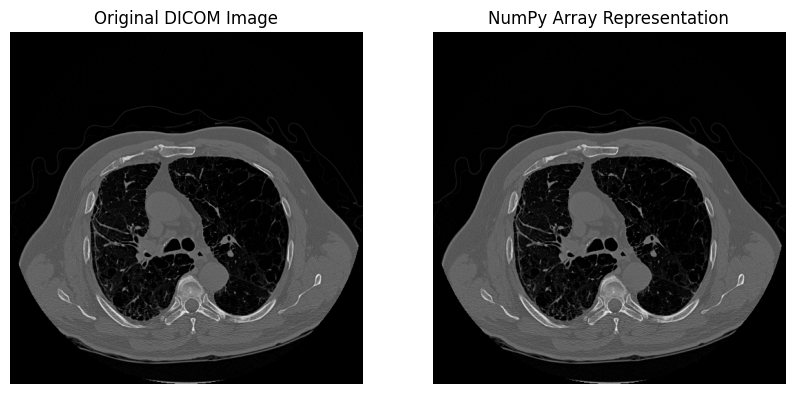

92__CT-1298-0014


In [31]:
list_slices = list(i for i in df_fibrosis["SliceID"])
slice_choice = random.choice(list_slices)
sanity_check(slice_choice, plot=True)

print(slice_choice)

In [34]:
# Identify errors
errors_list = []

for i in range(len(list_slices)):
    val = sanity_check(df_fibrosis["SliceID"].iloc[i])
    if val != "No error!": errors_list.append(val)

if len(errors_list) == 0: print("No errors!")
else: 
    for i in errors_list: print(i)

No errors!


## Creating .np files directory for easy access

To prevent memory issues later on, I will create a folder containing `.np_array` files, each named after its corresponding `SliceID`, with the file contents storing the values from `SliceData`:

In [39]:
# Creates output folder if it doesn’t exist
output_folder = "../../np_ROI_data"
os.makedirs(output_folder, exist_ok=True)

# Saves each slice as a .npy file
for i in tqdm(range(len(df_fibrosis)), desc="Uploading slice data to np files..."):
    sliceID = df_fibrosis["SliceID"].iloc[i]
    sliceData = df_fibrosis["SliceData"].iloc[i]
    file_path = os.path.join(output_folder, f"{sliceID}.npy")
    np.save(file_path, sliceData)

print("All slices saved successfully.")

Uploading slice data to np files...: 100%|██████████| 3075/3075 [00:27<00:00, 111.73it/s]

All slices saved successfully.
